### Preparing & Split Data

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Load the data
df = pd.read_excel('/Users/jinnanut/Library/Mobile Documents/com~apple~CloudDocs/NUT/Exeter University/Master/Term 3/BEMM466 Business Project/Dissertation/Data/WeeklyData.xlsx')
df['date'] = pd.to_datetime(df['date'])

# Get unique categories
categories = df['category'].unique()

# Create a dictionary to hold results
category_data = {}

# Define 5-week test window
test_window = pd.Timedelta(weeks=5)

# Use a single weekly anchor everywhere
W_ANCHOR = 'W-SUN'  # Sunday week-end

for cat in categories:
    print(f"\nProcessing category: {cat}")
    
    # Filter and sort
    df_cat = df[df["category"] == cat].copy()
    df_cat = df_cat.set_index('date').sort_index()

    # Resample to weekly on the chosen anchor
    df_cat = df_cat[["quantity"]].resample(W_ANCHOR, label="right", closed="right").sum()

    # Force a complete weekly grid on that anchor (handles gaps/missing weeks)
    if not df_cat.empty:
        full_idx = pd.date_range(df_cat.index.min(), df_cat.index.max(), freq=W_ANCHOR)
        df_cat = df_cat.reindex(full_idx).fillna(0.0)
        df_cat.index.name = "date"

        # Robust sanity checks
        assert df_cat.index.is_monotonic_increasing, "Index not increasing"
        deltas = df_cat.index.to_series().diff().dropna()
        assert (deltas == pd.Timedelta(weeks=1)).all(), "Index is not strictly weekly spaced"

    # Initialize storage
    category_data[cat] = {"full": df_cat}

    # Walk-forward parameters
    start_train = pd.Timestamp("2019-01-01")
    end_of_data = df_cat.index.max() if not df_cat.empty else None

    split_idx = 1
    test_start = start_train + pd.Timedelta(weeks=52)  # start after 1 year of training
    test_end = test_start + test_window - pd.Timedelta(days=1)

    while end_of_data is not None and test_end <= end_of_data:
        train_start = start_train
        train_end = test_start - pd.Timedelta(days=1)

        train_data = df_cat.loc[train_start:train_end]
        test_data = df_cat.loc[test_start:test_end]

        if train_data.empty or test_data.empty:
            print(f"  Skipping split {split_idx}: empty train or test")
        else:
            category_data[cat][f"train_{split_idx}"] = train_data
            category_data[cat][f"test_{split_idx}"] = test_data
            print(f"  Split {split_idx}: Train = {train_start.date()} to {train_end.date()}, "
                  f"Test = {test_start.date()} to {test_end.date()}")

        # Move test window forward by 5 weeks
        test_start += test_window
        test_end = test_start + test_window - pd.Timedelta(days=1)
        split_idx += 1

# Preview data
if len(categories) > 0:
    sample_cat = categories[0]
    print(f"\nPreview for category '{sample_cat}':")
    print(category_data[sample_cat]["full"].head())



Processing category: Furniture
  Split 1: Train = 2019-01-01 to 2019-12-30, Test = 2019-12-31 to 2020-02-03
  Split 2: Train = 2019-01-01 to 2020-02-03, Test = 2020-02-04 to 2020-03-09
  Split 3: Train = 2019-01-01 to 2020-03-09, Test = 2020-03-10 to 2020-04-13
  Split 4: Train = 2019-01-01 to 2020-04-13, Test = 2020-04-14 to 2020-05-18
  Split 5: Train = 2019-01-01 to 2020-05-18, Test = 2020-05-19 to 2020-06-22
  Split 6: Train = 2019-01-01 to 2020-06-22, Test = 2020-06-23 to 2020-07-27
  Split 7: Train = 2019-01-01 to 2020-07-27, Test = 2020-07-28 to 2020-08-31
  Split 8: Train = 2019-01-01 to 2020-08-31, Test = 2020-09-01 to 2020-10-05
  Split 9: Train = 2019-01-01 to 2020-10-05, Test = 2020-10-06 to 2020-11-09
  Split 10: Train = 2019-01-01 to 2020-11-09, Test = 2020-11-10 to 2020-12-14
  Split 11: Train = 2019-01-01 to 2020-12-14, Test = 2020-12-15 to 2021-01-18
  Split 12: Train = 2019-01-01 to 2021-01-18, Test = 2021-01-19 to 2021-02-22
  Split 13: Train = 2019-01-01 to 2021-02

# Monte Carlo Simulation

### 1. Find Seasonal Index & Deseasonalize

In [3]:
import numpy as np

seasonality_results = {}

for cat in categories:
    print(f"\nProcessing seasonal index for: {cat}")

    if cat not in category_data:
        print(f"  Skipping {cat}: no data.")
        continue

    seasonality_results[cat] = {}

    for key in category_data[cat]:
        if not key.startswith("train_"):
            continue

        train_df = category_data[cat][key].copy()
        if train_df.empty:
            print(f"  Skipping {cat} - {key}: empty train data.")
            continue

        # Ensure weekly index anchor consistent
        assert train_df.index.inferred_freq in (None, 'W-SUN'), "Non-weekly train index"
        
        train_df["week"] = train_df.index.isocalendar().week

        overall_avg = train_df["quantity"].mean()
        weekly_avg = train_df.groupby("week")["quantity"].mean()
        seasonal_index = weekly_avg / overall_avg

        train_df["seasonal_index"] = train_df["week"].map(seasonal_index)

        train_df["deseasonalized"] = train_df["quantity"] / train_df["seasonal_index"].replace(0, np.nan)
        train_df.dropna(subset=["deseasonalized"], inplace=True)

        seasonality_results[cat][key] = {
            "seasonal_index": seasonal_index,
            "deseasonalized_train": train_df
        }

        print(f"  Done {cat} - {key}: {len(train_df)} points deseasonalized.")



Processing seasonal index for: Furniture
  Done Furniture - train_1: 28 points deseasonalized.
  Done Furniture - train_2: 32 points deseasonalized.
  Done Furniture - train_3: 36 points deseasonalized.
  Done Furniture - train_4: 39 points deseasonalized.
  Done Furniture - train_5: 43 points deseasonalized.
  Done Furniture - train_6: 46 points deseasonalized.
  Done Furniture - train_7: 48 points deseasonalized.
  Done Furniture - train_8: 51 points deseasonalized.
  Done Furniture - train_9: 54 points deseasonalized.
  Done Furniture - train_10: 59 points deseasonalized.
  Done Furniture - train_11: 62 points deseasonalized.
  Done Furniture - train_12: 65 points deseasonalized.
  Done Furniture - train_13: 68 points deseasonalized.
  Done Furniture - train_14: 71 points deseasonalized.
  Done Furniture - train_15: 79 points deseasonalized.
  Done Furniture - train_16: 83 points deseasonalized.
  Done Furniture - train_17: 89 points deseasonalized.
  Done Furniture - train_18: 95 

### 2. Fit Probability Distribution

In [4]:
# Fit Probability Distribution (RSS + KS)
from scipy import stats

# candidates to try
CANDIDATES = {
    "loggamma": stats.loggamma,
    "lognorm":  stats.lognorm,
    "gamma":    stats.gamma,
    "norm":     stats.norm
}

def fit_best_distribution(y, bins=50):
    """
    Fit candidate distributions to 1D data y.
    Uses RSS between empirical histogram and model PDF over bin centers.
    Also computes KS statistic for the best fit as a sanity check.
    Returns: dict(name, dist, params, rss, ks_stat, ks_pvalue)
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]  # clean
    if y.size < 10:
        return None

    # empirical histogram (if density=True so it approximates PDF)
    hist, bin_edges = np.histogram(y, bins=bins, density=True)
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    best = {"name": None, "dist": None, "params": None,
            "rss": np.inf, "ks_stat": None, "ks_pvalue": None}

    for name, dist in CANDIDATES.items():
        try:
            # Fit distribution params to data
            params = dist.fit(y)   # returns (shape(s), loc, scale)
            # Model pdf at empirical bin centers
            model_pdf = dist.pdf(centers, *params)
            # Residual sum of squares vs histogram heights
            rss = np.sum((hist - model_pdf)**2)

            if rss < best["rss"]:
                best.update({"name": name, "dist": dist, "params": params, "rss": rss})
        except Exception:
            continue

    # KS validation for the chosen model
    if best["dist"] is not None:
        ks_stat, ks_p = stats.kstest(y, best["dist"].cdf, args=best["params"])
        best["ks_stat"], best["ks_pvalue"] = ks_stat, ks_p

    return best

# Store results per category & split
distribution_results = {}

for cat in seasonality_results:
    print(f"\nFitting probability distributions for category: {cat}")
    distribution_results[cat] = {}

    for train_key, payload in seasonality_results[cat].items():
        if not train_key.startswith("train_"):
            continue

        train_df = payload["deseasonalized_train"]
        if train_df.empty:
            print(f"  Skipping {cat} - {train_key}: empty.")
            continue

        y = train_df["deseasonalized"].values
        best = fit_best_distribution(y, bins=50)

        if best is None or best["name"] is None:
            print(f"  {train_key}: No valid fit.")
            continue

        distribution_results[cat][train_key] = best
        print(f"  {train_key}: Best = {best['name']} | RSS={best['rss']:.4g} | "
              f"KS stat={best['ks_stat']:.3f}, p={best['ks_pvalue']:.3f}")



Fitting probability distributions for category: Furniture
  train_1: No valid fit.
  train_2: Best = norm | RSS=1.893 | KS stat=0.406, p=0.000
  train_3: Best = norm | RSS=1.137 | KS stat=0.306, p=0.002
  train_4: Best = norm | RSS=0.8019 | KS stat=0.244, p=0.016
  train_5: Best = norm | RSS=0.4325 | KS stat=0.198, p=0.060
  train_6: Best = norm | RSS=0.3272 | KS stat=0.161, p=0.167
  train_7: Best = norm | RSS=0.325 | KS stat=0.155, p=0.180


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5897: RuntimeWarning: overflow encountered in exp
  return c*x - np.exp(x) - sc.gammaln(c)
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  train_8: Best = norm | RSS=0.2257 | KS stat=0.137, p=0.271
  train_9: Best = norm | RSS=0.1408 | KS stat=0.096, p=0.670
  train_10: Best = norm | RSS=0.1457 | KS stat=0.079, p=0.823
  train_11: Best = gamma | RSS=0.1259 | KS stat=0.063, p=0.952
  train_12: Best = loggamma | RSS=0.1045 | KS stat=0.063, p=0.947
  train_13: Best = norm | RSS=0.04567 | KS stat=0.061, p=0.950
  train_14: Best = norm | RSS=0.04895 | KS stat=0.061, p=0.939
  train_15: Best = gamma | RSS=0.04801 | KS stat=0.353, p=0.000
  train_16: Best = norm | RSS=0.04621 | KS stat=0.095, p=0.419
  train_17: Best = gamma | RSS=0.04471 | KS stat=0.349, p=0.000
  train_18: Best = gamma | RSS=0.05032 | KS stat=0.296, p=0.000
  train_19: Best = gamma | RSS=0.03937 | KS stat=0.357, p=0.000
  train_20: Best = gamma | RSS=0.04059 | KS stat=0.539, p=0.000
  train_21: Best = gamma | RSS=0.06471 | KS stat=0.293, p=0.000
  train_22: Best = gamma | RSS=0.04023 | KS stat=0.546, p=0.000
  train_23: Best = gamma | RSS=0.03946 | KS stat=0

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:5894: RuntimeWarning: overflow encountered in exp
  return np.exp(c*x-np.exp(x)-sc.gammaln(c))
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


  train_3: Best = norm | RSS=0.3744 | KS stat=0.313, p=0.001
  train_4: Best = norm | RSS=0.2744 | KS stat=0.276, p=0.003
  train_5: Best = norm | RSS=0.09583 | KS stat=0.232, p=0.015
  train_6: Best = gamma | RSS=0.06217 | KS stat=0.187, p=0.065
  train_7: Best = norm | RSS=0.04402 | KS stat=0.158, p=0.155
  train_8: Best = norm | RSS=0.02395 | KS stat=0.109, p=0.518
  train_9: Best = norm | RSS=0.01482 | KS stat=0.088, p=0.747
  train_10: Best = norm | RSS=0.01375 | KS stat=0.093, p=0.637
  train_11: Best = gamma | RSS=0.01273 | KS stat=0.087, p=0.691
  train_12: Best = gamma | RSS=0.01195 | KS stat=0.096, p=0.531
  train_13: Best = gamma | RSS=0.01029 | KS stat=0.086, p=0.649
  train_14: Best = gamma | RSS=0.01003 | KS stat=0.089, p=0.576
  train_15: Best = norm | RSS=0.005595 | KS stat=0.095, p=0.425
  train_16: Best = norm | RSS=0.005087 | KS stat=0.094, p=0.420
  train_17: Best = norm | RSS=0.006149 | KS stat=0.089, p=0.435
  train_18: Best = gamma | RSS=0.006052 | KS stat=0.299,

### 3. Generate Randomness from Fitted Distribution

In [5]:
# Choose replication count
N_SIM = 50000  

montecarlo_inputs = {}

for cat in distribution_results:
    print(f"\nGenerating Monte Carlo samples for: {cat}")
    montecarlo_inputs[cat] = {}

    for train_key, best in distribution_results[cat].items():
        dist, params = best["dist"], best["params"]
        # Draw samples directly from the fitted theoretical distribution
        samples = dist.rvs(*params, size=N_SIM, random_state=42)
        montecarlo_inputs[cat][train_key] = {"samples": samples}
        print(f"  {train_key}: generated {samples.size:,} samples from {best['name']}")



Generating Monte Carlo samples for: Furniture
  train_2: generated 50,000 samples from norm
  train_3: generated 50,000 samples from norm
  train_4: generated 50,000 samples from norm
  train_5: generated 50,000 samples from norm
  train_6: generated 50,000 samples from norm
  train_7: generated 50,000 samples from norm
  train_8: generated 50,000 samples from norm
  train_9: generated 50,000 samples from norm
  train_10: generated 50,000 samples from norm
  train_11: generated 50,000 samples from gamma
  train_12: generated 50,000 samples from loggamma
  train_13: generated 50,000 samples from norm
  train_14: generated 50,000 samples from norm
  train_15: generated 50,000 samples from gamma
  train_16: generated 50,000 samples from norm
  train_17: generated 50,000 samples from gamma
  train_18: generated 50,000 samples from gamma
  train_19: generated 50,000 samples from gamma
  train_20: generated 50,000 samples from gamma
  train_21: generated 50,000 samples from gamma
  train_22

### 4. Reintroduce Seasonality

In [6]:
simulated_demands = {}

for cat in distribution_results:
    print(f"\nReintroducing seasonality for category: {cat}")
    simulated_demands[cat] = {}

    for train_key, best in distribution_results[cat].items():
        train_df = seasonality_results[cat][train_key]["deseasonalized_train"]
        idx = train_df.index
        T = len(train_df)
        assert T > 0

        K = max(1, N_SIM // T)

        draws = montecarlo_inputs[cat][train_key]["samples"][:T*K]
        sim_deseason = draws.reshape(T, K)

        seasonal = train_df["seasonal_index"].to_numpy().reshape(-1, 1)
        sim_with_season = sim_deseason * seasonal

        # Ensure index is weekly anchored
        assert idx.is_monotonic_increasing

        simulated_demands[cat][train_key] = {
            "simulated_demand": sim_with_season,  # (T, K)
            "index": idx
        }

        print(f"  {train_key}: simulated matrix {sim_with_season.shape} (T x K)")



Reintroducing seasonality for category: Furniture
  train_2: simulated matrix (32, 1562) (T x K)
  train_3: simulated matrix (36, 1388) (T x K)
  train_4: simulated matrix (39, 1282) (T x K)
  train_5: simulated matrix (43, 1162) (T x K)
  train_6: simulated matrix (46, 1086) (T x K)
  train_7: simulated matrix (48, 1041) (T x K)
  train_8: simulated matrix (51, 980) (T x K)
  train_9: simulated matrix (54, 925) (T x K)
  train_10: simulated matrix (59, 847) (T x K)
  train_11: simulated matrix (62, 806) (T x K)
  train_12: simulated matrix (65, 769) (T x K)
  train_13: simulated matrix (68, 735) (T x K)
  train_14: simulated matrix (71, 704) (T x K)
  train_15: simulated matrix (79, 632) (T x K)
  train_16: simulated matrix (83, 602) (T x K)
  train_17: simulated matrix (89, 561) (T x K)
  train_18: simulated matrix (95, 526) (T x K)
  train_19: simulated matrix (101, 495) (T x K)
  train_20: simulated matrix (107, 467) (T x K)
  train_21: simulated matrix (110, 454) (T x K)
  train_

### 5. Aggregate & Summarize Simulated Demand

In [7]:
weekly_summary = {}

for cat in simulated_demands:
    print(f"\nAggregating weekly simulated demand for: {cat}")
    weekly_summary[cat] = {}

    for train_key in simulated_demands[cat]:
        sim_demand = simulated_demands[cat][train_key]["simulated_demand"]
        index = simulated_demands[cat][train_key]["index"]

        # Build DataFrame
        sim_df = pd.DataFrame(sim_demand, index=index)
        sim_weekly = sim_df.resample('W-SUN').sum()

        mean_forecast = sim_weekly.mean(axis=1)
        p10 = sim_weekly.quantile(0.10, axis=1)
        p90 = sim_weekly.quantile(0.90, axis=1)

        weekly_summary[cat][train_key] = pd.DataFrame({
            "mean_forecast": mean_forecast,
            "p10": p10,
            "p90": p90
        })

        print(f"  {train_key}: {len(mean_forecast)} weekly points aggregated")



Aggregating weekly simulated demand for: Furniture
  train_2: 57 weekly points aggregated
  train_3: 62 weekly points aggregated
  train_4: 67 weekly points aggregated
  train_5: 72 weekly points aggregated
  train_6: 76 weekly points aggregated
  train_7: 80 weekly points aggregated
  train_8: 85 weekly points aggregated
  train_9: 92 weekly points aggregated
  train_10: 97 weekly points aggregated
  train_11: 102 weekly points aggregated
  train_12: 107 weekly points aggregated
  train_13: 112 weekly points aggregated
  train_14: 116 weekly points aggregated
  train_15: 122 weekly points aggregated
  train_16: 127 weekly points aggregated
  train_17: 132 weekly points aggregated
  train_18: 137 weekly points aggregated
  train_19: 142 weekly points aggregated
  train_20: 147 weekly points aggregated
  train_21: 151 weekly points aggregated
  train_22: 157 weekly points aggregated
  train_23: 162 weekly points aggregated
  train_24: 167 weekly points aggregated
  train_25: 172 weekly

### 6. Ploting Graph to Analysis


Building overall TEST forecast for: Furniture


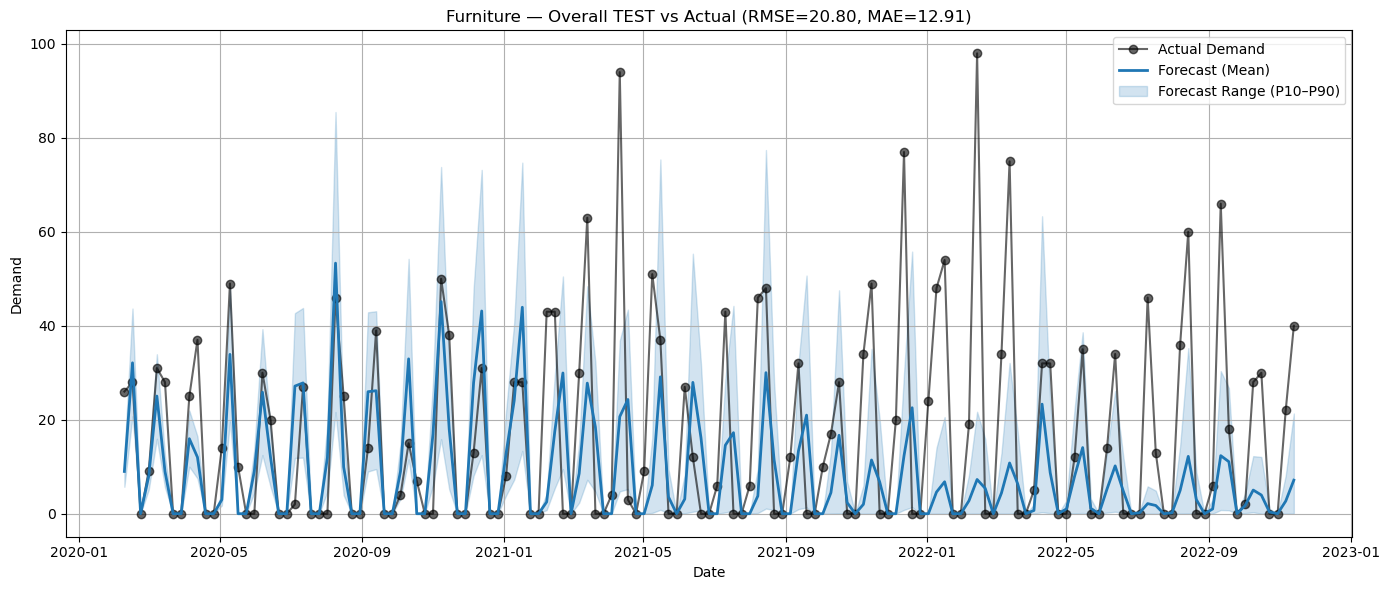


Building overall TEST forecast for: Office Supplies


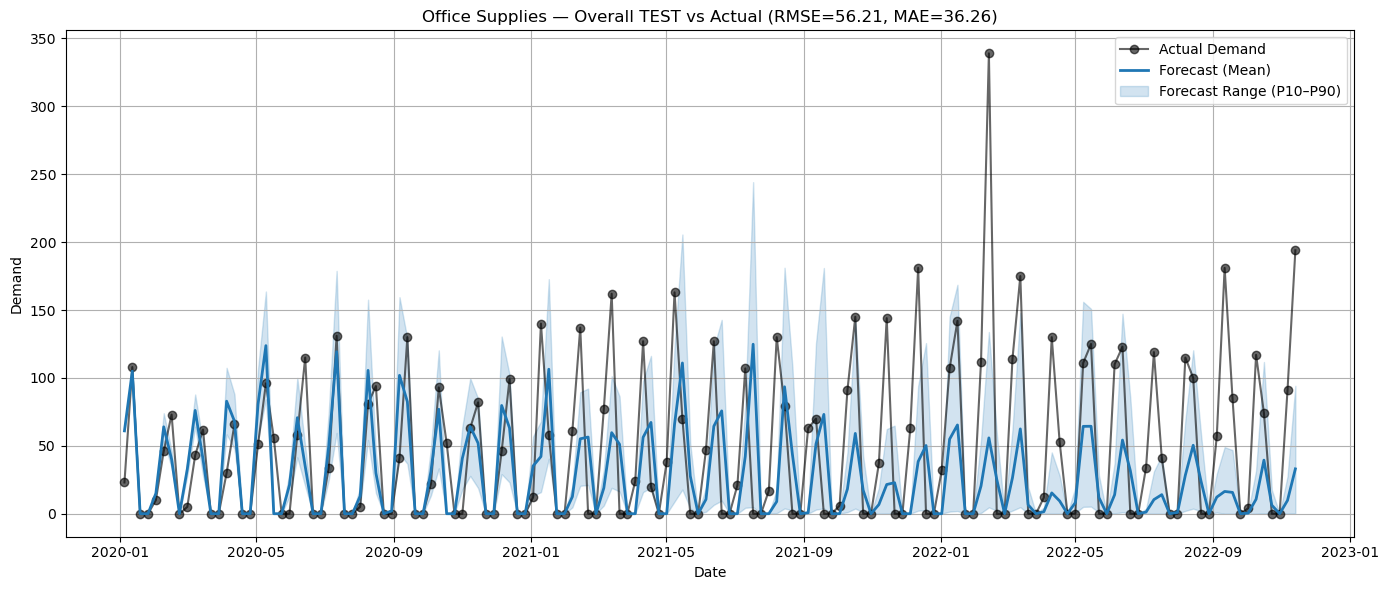


Building overall TEST forecast for: Technology


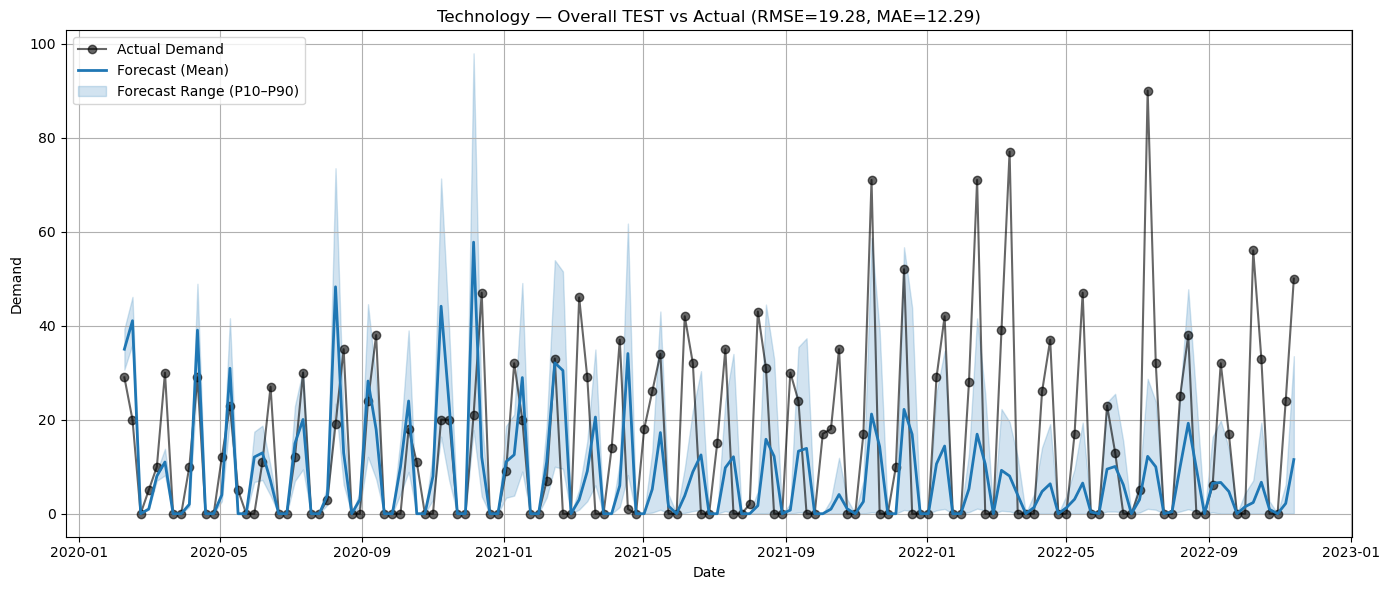

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_forecasts = {} 

for cat in categories:
    print(f"\nBuilding overall TEST forecast for: {cat}")

    # Collect per-split TEST summaries
    test_rows = []

    # Pull the actuals from the resampled raw series on the same dates
    raw_weekly = category_data[cat]["full"] 

    # Iterate test_* splits for each category
    for key in sorted(category_data[cat].keys()):
        if not key.startswith("test_"):
            continue

        test_df = category_data[cat][key]
        if test_df.empty:
            continue

        # Find the matching train split (for distribution + seasonal index)
        split_num = key.split("_")[1]
        train_key = f"train_{split_num}"
        if (cat not in seasonality_results or
            train_key not in seasonality_results[cat] or
            cat not in distribution_results or
            train_key not in distribution_results[cat]):
            # Skip if we don't have the learned pieces for this split
            continue

        # Draw TEST-length Monte Carlo samples from the fitted TRAIN distribution
        dist = distribution_results[cat][train_key]["dist"]
        params = distribution_results[cat][train_key]["params"]

        T_test = len(test_df.index)
        K_test = max(1, N_SIM // T_test)  # same idea as Step 4
        draws = dist.rvs(*params, size=T_test * K_test, random_state=42)
        sim_deseason = draws.reshape(T_test, K_test)

        # Reintroduce seasonality for the TEST weeks using TRAIN seasonal index mapping
        seasonal_index_train = seasonality_results[cat][train_key]["seasonal_index"]  # by ISO week 1..52
        test_weeks = test_df.index.isocalendar().week  # could include 53 in rare cases

        # Map week->index; if any weeks not found (e.g., 53), backfill with the mean seasonal index
        seasonal_vals = test_weeks.map(seasonal_index_train)
        seasonal_vals = seasonal_vals.fillna(seasonal_index_train.mean()).to_numpy().reshape(-1, 1)

        sim_with_season = sim_deseason * seasonal_vals

        # Aggregate across simulations: mean / p10 / p90
        sim_df = pd.DataFrame(sim_with_season, index=test_df.index)
        summary = pd.DataFrame({
            "mean_forecast": sim_df.mean(axis=1),
            "p10":           sim_df.quantile(0.10, axis=1),
            "p90":           sim_df.quantile(0.90, axis=1),
        })

        # Actuals from the resampled raw data on the same dates
        summary["actual"] = raw_weekly.reindex(summary.index)["quantity"]

        # Keep split label
        summary["split"] = key
        test_rows.append(summary)

    if not test_rows:
        print(f"  No TEST windows available for {cat}.")
        continue

    # Concatenate all TEST windows, sort by date
    big_test = pd.concat(test_rows).sort_index()

    # Final alignment guard (in case of any NaNs)
    big_test = big_test.dropna(subset=["mean_forecast", "actual"])

    # Score on ALL TEST data for each category
    rmse = mean_squared_error(big_test["actual"], big_test["mean_forecast"], squared=False)
    mae  = mean_absolute_error(big_test["actual"], big_test["mean_forecast"])
    test_forecasts[cat] = big_test

    # Plotting
    plt.figure(figsize=(14, 6))
    # Actuals (one continuous TEST line)
    plt.plot(big_test.index, big_test["actual"].values, label="Actual Demand",
             color="black", linestyle="-", marker="o", alpha=0.6)

    # Forecast mean
    plt.plot(big_test.index, big_test["mean_forecast"].values, label="Forecast (Mean)",
             color="tab:blue", linewidth=2)

    # P10–P90 band
    plt.fill_between(big_test.index, big_test["p10"].values, big_test["p90"].values,
                     color="tab:blue", alpha=0.2, label="Forecast Range (P10–P90)")

    plt.title(f"{cat} — Overall TEST vs Actual (RMSE={rmse:.2f}, MAE={mae:.2f})")
    plt.xlabel("Date"); plt.ylabel("Demand")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


### Summary Report

In [9]:
# Weekly Monte Carlo Summary

summary_rows_weekly = []

for cat in simulated_demands:
    for train_key, sim_out in simulated_demands[cat].items():
        sims = sim_out["simulated_demand"]  # shape: (T x K)
        idx = sim_out["index"]

        # Compute statistics across simulations (axis=1 = week level)
        sim_min = sims.min(axis=1)
        sim_max = sims.max(axis=1)
        sim_mean = sims.mean(axis=1)
        sim_median = np.median(sims, axis=1)
        sim_std = sims.std(axis=1)
        sim_p10 = np.percentile(sims, 10, axis=1)
        sim_p90 = np.percentile(sims, 90, axis=1)

        # Collect per-week summary rows
        for dt, mn, mx, mean, med, sd, p10, p90 in zip(
            idx, sim_min, sim_max, sim_mean, sim_median, sim_std, sim_p10, sim_p90
        ):
            summary_rows_weekly.append({
                "Category": cat,
                "Period": "Weekly",
                "Year": dt.year,
                "Week": dt.isocalendar().week,
                "Date": dt.strftime("%Y-%m-%d"),
                "Min": mn,
                "Max": mx,
                "Mean": mean,
                "Median": med,
                "StdDev": sd,
                "P10": p10,
                "P90": p90,
                "N_Sim": sims.shape[1]
            })

# Convert to DataFrame
weekly_summary_df = pd.DataFrame(summary_rows_weekly)

# Preview first 10 rows
print("Weekly summary preview:")
print(weekly_summary_df.head(10))

# Export to Excel
weekly_summary_df.to_excel("MCR_summary_weekly.xlsx", sheet_name="Weekly", index=False)
print("\nWeekly summary exported to MCR_summary_weekly.xlsx")


Weekly summary preview:
    Category  Period  Year  Week        Date       Min        Max       Mean  \
0  Furniture  Weekly  2019     1  2019-01-06  2.144897  49.978062  24.314310   
1  Furniture  Weekly  2019     2  2019-01-13  6.673590  92.535111  44.090558   
2  Furniture  Weekly  2019     5  2019-02-03  0.387525   4.777856   2.476153   
3  Furniture  Weekly  2019     6  2019-02-10  0.967588  16.871108   8.928382   
4  Furniture  Weekly  2019     7  2019-02-17 -1.159706  63.727452  31.802321   
5  Furniture  Weekly  2019     9  2019-03-03 -0.623222  15.590966   8.056017   
6  Furniture  Weekly  2019    10  2019-03-10 -2.549815  45.467868  24.757536   
7  Furniture  Weekly  2019    11  2019-03-17  0.464724  17.540811   9.014218   
8  Furniture  Weekly  2019    14  2019-04-07  2.143339  31.413558  16.157792   
9  Furniture  Weekly  2019    15  2019-04-14 -0.255650  22.587566  12.029046   

      Median     StdDev        P10        P90  N_Sim  
0  24.310195   6.676918  15.735940  33.2

### Top risk periods

In [10]:
def top_risk_weeks(weekly_summary_df, category, k=10):
    df = (
        weekly_summary_df
        .query("Category == @category and Period == 'Weekly'")
        .copy()
    )
    if df.empty:
        print(f"No weekly data for category '{category}'.")
        return pd.DataFrame()

    df["Date"] = pd.to_datetime(df["Date"])
    out = df.sort_values("StdDev", ascending=False).head(k)
    cols = ["Category","Year","Week","Date","Mean","P10","P90","StdDev","Min","Max","N_Sim"]
    return out[cols]

# Example
top_risk_weeks(weekly_summary_df, "Furniture", k=10)


,Category,Year,Week,Date,Mean,P10,P90,StdDev,Min,Max,N_Sim
1065,Furniture,2020,14,2020-04-05,35.426256,0.074842,109.568312,59.624665,1.088994e-06,588.601246,495
1052,Furniture,2019,45,2019-11-10,31.394211,0.222705,84.670934,58.527915,3.187185e-09,472.477983,495
1043,Furniture,2019,32,2019-08-11,33.627569,0.144373,91.828839,57.190397,8.356854e-10,429.989455,495
1102,Furniture,2021,14,2021-04-11,30.914019,0.034248,94.763203,55.004592,5.997820e-10,463.043448,495
1088,Furniture,2020,45,2020-11-08,32.040123,0.060418,85.665900,54.738224,4.122215e-06,469.229072,495
1079,Furniture,2020,32,2020-08-09,34.229480,0.182171,96.602300,52.776952,1.268212e-06,444.598592,495
1116,Furniture,2021,32,2021-08-15,32.239162,0.093352,93.479324,51.468195,6.000601e-10,334.588783,495
1094,Furniture,2021,2,2021-01-17,28.493871,0.081995,86.564090,48.825678,4.282043e-07,291.042692,495
1029,Furniture,2019,14,2019-04-07,33.337251,0.117720,95.386181,48.761084,3.033900e-06,329.533039,495
1069,Furniture,2020,19,2020-05-10,27.349652,0.110769,78.477908,47.125447,9.167684e-07,344.259728,495
